# Part 1 Bagged Decision Tree

In this homework you are gonna learn 2 things how to use all processor on your machine(in python) and Bagged(Bootstrap Aggregating) Decision Tree.

Bagging(Bootstrap Aggregating) is a common way to prevent overfitting. The idea is to make a bunch of trees. Each with a handicapped data. To handicap the data, one could either use just the subset or just remove some features.

Then after you get a bunch of classifiers(trees) all we need to do is average the output.

Consider the following data write a Bagged Decision Tree out of it.

- For each tree use roughly half the sample (`np.random.choice` is your friend)
- Use minleaf of 20 or so.
- Train 100 trees.
- Make contour plot.

In [1]:
%matplotlib inline
import numpy as np
import math
import pydot
from matplotlib import pyplot as plt
from IPython.display import Image, display
from multiprocessing import Pool


import os
import time
import sys

(-5, 5)

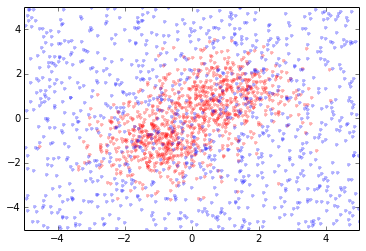

In [2]:
np.random.seed(1234)
nset = 500
xp11 = np.random.randn(nset,1)-1
xp21 = np.random.randn(nset,1)-1

xp12 = np.random.randn(nset,1)+1
xp22 = np.random.randn(nset,1)+1

xp1 = np.concatenate((xp11, xp12))
xp2 = np.concatenate((xp21, xp22))

pcls = np.zeros((nset*2))
pcls[:] = 1

xn1 = np.random.random((nset*2,1))*10-5
xn2 = np.random.random((nset*2,1))*10-5
ncls = np.zeros((1000))
ncls[:] = -1

x1s = np.concatenate([xp1, xn1])
x2s = np.concatenate([xp2, xn2])
cls = np.concatenate([pcls, ncls])
features = np.concatenate((x1s, x2s), axis=1)

cls>0
plt.plot(features[cls>0, 0], features[cls>0, 1], '.r', alpha=0.3)
plt.plot(features[cls<0, 0], features[cls<0, 1], '.b', alpha=0.3)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

In [3]:
print features.shape

(2000, 2)


In [4]:
class Node:
    def __init__(self, msg='label'):
        self.left = None
        self.right = None
        self.msg = msg
        
    def is_leaf(self):
        return self.left is None and self.right is None
    
    def __str__(self):
        return self.msg
    
class DecisionNode(Node):
    def __init__(self, vid, cut, prob = -1):
        Node.__init__(self)
        self.vid = vid
        self.cut = cut
        self.prob = prob

    def __str__(self):
        if not self.is_leaf():
            return 'x%d < %.2f'%(self.vid, self.cut)
        else:
            return '%.2f'%self.prob
            
    def classify(self, data):
        if self.is_leaf():
            return self.prob
        else:
            if (data[self.vid] < self.cut):
                return self.left.classify(data)
            else:
                return self.right.classify(data)

def make_tree(data):
    features, cls, minleaf = data
    if len(features) < minleaf:
        return DecisionNode(None, None, sum(cls>0)/float(len(features)))
    elif sum(cls>0) == len(cls):
        return DecisionNode(None, None, 1 if cls[0] > 0 else 0)
    else:
        vid, cut, s, left, ftLeft, right, ftRight = find_cut(features, cls)
        node = DecisionNode(vid, cut)
        node.left = make_tree((ftLeft, left, minleaf))
        node.right = make_tree((ftRight, right, minleaf))
        
        return node

In [5]:
def score(cls):
    p = sum(cls>0)/float(len(cls))
    return p*(1 - p)
    
def find_cut(features, cls):
    nfeatures = features.shape[1]
    result = []
    for vid in xrange(nfeatures):
        xs = features[:, vid]
        minx, maxx = min(xs), max(xs)
        cuts = np.linspace(minx, maxx, 12)[1: - 1]
        
        for cut in cuts:
            left = cls[xs<cut]
            ftLeft = features[xs<cut]
            right = cls[xs>=cut]
            ftRight = features[xs>=cut]
            s = score(left) + score(right)
            
            result.append((vid, cut, s, left, ftLeft, right, ftRight))
            
    return min(result, key = lambda x: x[2])

In [17]:
# find_cut(features, cls)

In [43]:
ntree = 100
minleaf = 20

randIdx = np.array([ np.array([np.random.randint(2) for x in xrange(len(features))]) for y in xrange(ntree)])
randPop = np.array([ (features[idx == 1], cls[idx == 1], minleaf) for idx in randIdx])

In [44]:
start_time = time.time()
forest = np.array([make_tree(data) for data in randPop])
print("--- %s seconds ---" % (time.time() - start_time))

--- 101.527846813 seconds ---


In [8]:
#Here are some helpers
#node must have field left and right representing left and right node.
#the label on the node is from __str__ method
def visualize_tree(node, depth_limit=10):
    graph = pydot.Dot(graph_type='digraph')
    visualize_tree_helper(node, graph, 0, depth_limit=depth_limit)
    display(Image(graph.create_png()))
    return graph
    
def visualize_tree_helper(node, graph, depth, depth_limit=10):
    
    if depth > depth_limit:
        print 'Traversing too deep'
        dotnode = pydot.Node('n%d'%id(node), label=str(node), shape="diamond", fillcolor="green", style="filled")
        graph.add_node(dotnode)
        return dotnode
    
    
    if not node.is_leaf():
        dotnode = pydot.Node('n%d'%id(node),label=str(node), shape="box")
    else:
        dotnode = pydot.Node('n%d'%id(node),label=str(node), shape="ellipse")
    graph.add_node(dotnode)
    
    if node.left is not None:
        dotleft = visualize_tree_helper(node.left, graph, depth+1, depth_limit)
        edge = pydot.Edge(dotnode, dotleft, label="Y")
        graph.add_edge(edge)
    if node.right is not None:
        dotright = visualize_tree_helper(node.right, graph, depth+1, depth_limit)
        edge = pydot.Edge(dotnode, dotright, label="N")
        graph.add_edge(edge)
    return dotnode

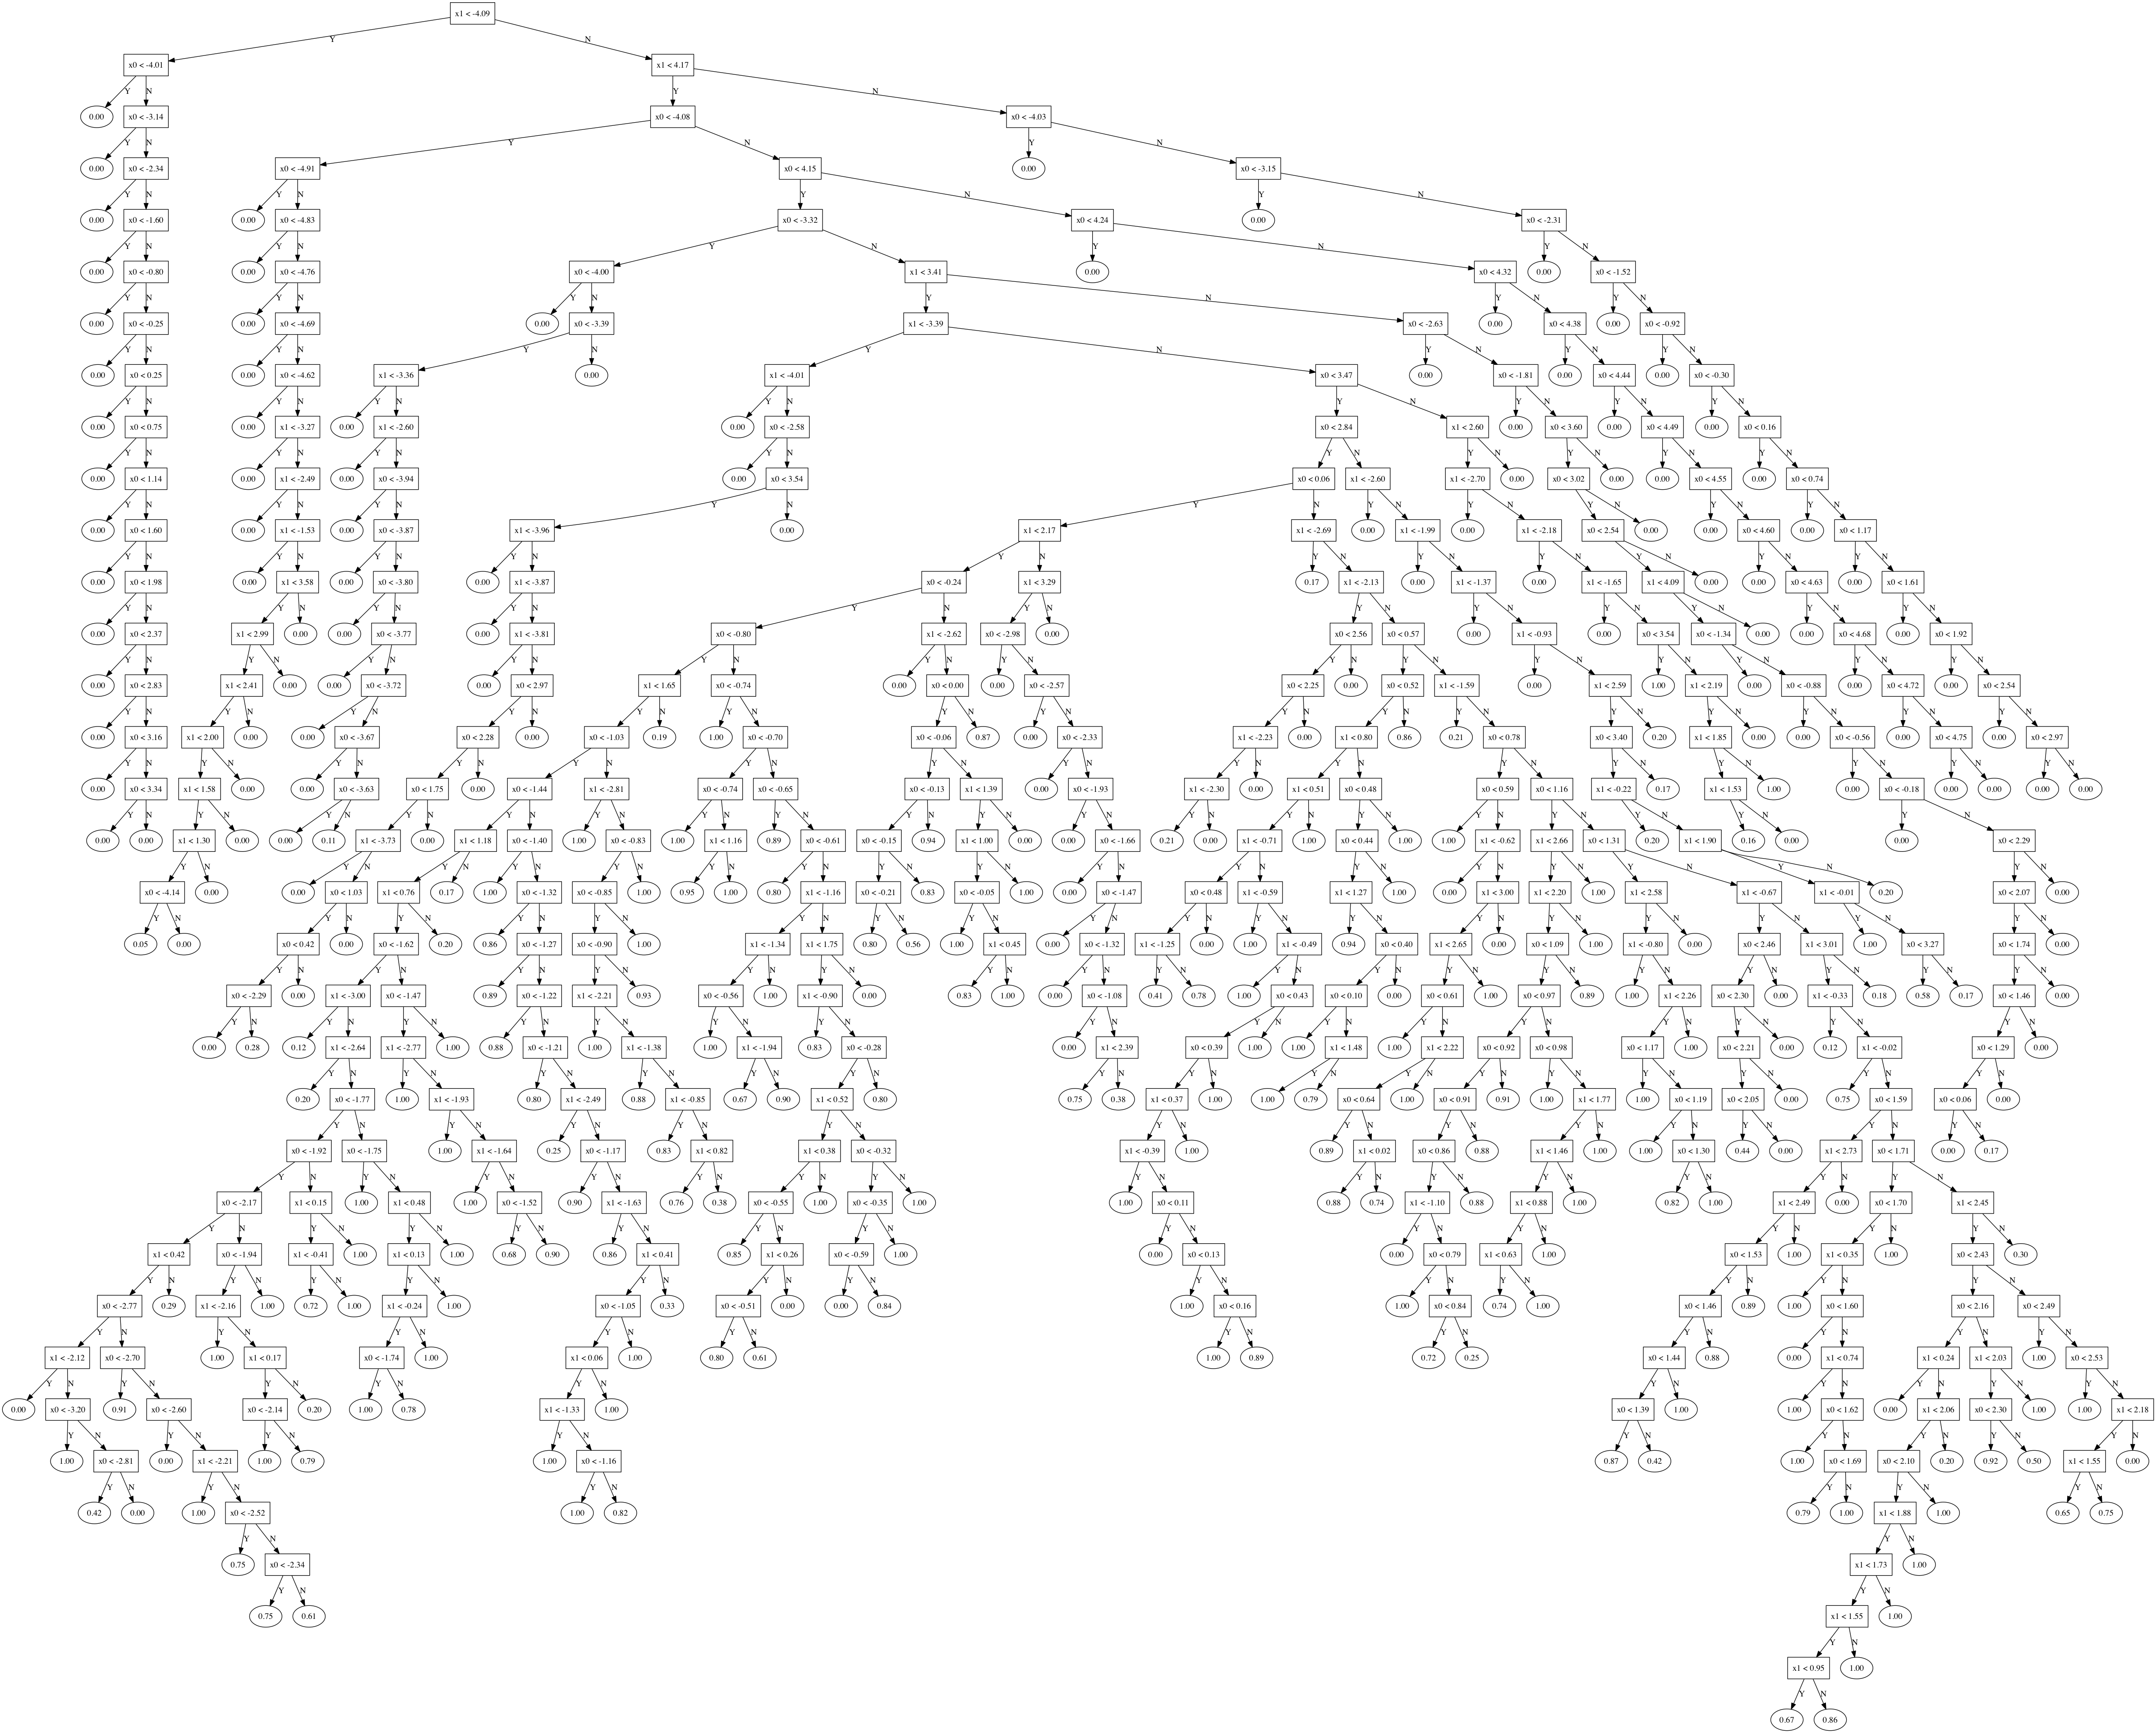

In [9]:
visualize_tree(tree, 40)

(-5, 5)

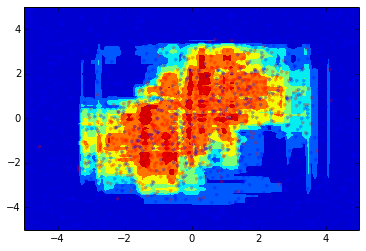

In [42]:
aa = np.linspace(-5, 5, 100)
bb = np.linspace(-5, 5, 100)
zs = np.zeros((100,100))

for ix1, a in enumerate(aa):
    for ix2, b in enumerate(bb):
        zs[ix1, ix2] = sum([tree.classify([a, b]) for tree in forest])/len(forest)
plt.contourf(aa, bb, zs.T)

np.random.seed(1234)
nset = 500
xp11 = np.random.randn(nset,1)-1
xp21 = np.random.randn(nset,1)-1

xp12 = np.random.randn(nset,1)+1
xp22 = np.random.randn(nset,1)+1

xp1 = np.concatenate((xp11, xp12))
xp2 = np.concatenate((xp21, xp22))

pcls = np.zeros((nset*2))
pcls[:] = 1

xn1 = np.random.random((nset*2,1))*10-5
xn2 = np.random.random((nset*2,1))*10-5
ncls = np.zeros((1000))
ncls[:] = -1

x1s = np.concatenate([xp1, xn1])
x2s = np.concatenate([xp2, xn2])
cls = np.concatenate([pcls, ncls])
features = np.concatenate((x1s, x2s), axis=1)

cls>0
plt.plot(features[cls>0, 0], features[cls>0, 1], '.r', alpha=0.3)
plt.plot(features[cls<0, 0], features[cls<0, 1], '.b', alpha=0.3)
plt.xlim(-5, 5)
plt.ylim(-5, 5)

# Part 2 Parallelize your code

You can see that training 100 trees takes quite a while. In this problem your job is to modify your code a little bit so that it uses all processor on your machine.

**Save often. There is a chance it will crash your computer.**

https://docs.python.org/2/library/multiprocessing.html

In [11]:
# from multiprocessing import Pool

def f(x):
    return x*x

p = Pool(5)
print(p.map(f, [1, 2, 3]))
p.close()

[1, 4, 9]


In [12]:
def g(x):
    return x**100000

In [13]:
lst = [ 1000 for l in xrange(1000)]

In [14]:
start_time = time.time()
for x in lst:
    g(x)
print("--- %s seconds ---" % (time.time() - start_time))

--- 34.2326109409 seconds ---


In [15]:
p = Pool(5)
start_time = time.time()
(p.map(g, lst))
print("--- %s seconds ---" % (time.time() - start_time))
p.close()

--- 17.612390995 seconds ---


In [16]:
start_time = time.time()
data = (features, cls, 20)
tree = make_tree(data)
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.57798409462 seconds ---


In [47]:
start_time = time.time()
p = Pool(100)
tforest = p.map(make_tree, randPop)
print("--- %s seconds ---" % (time.time() - start_time))

--- 56.8140099049 seconds ---


(-5, 5)

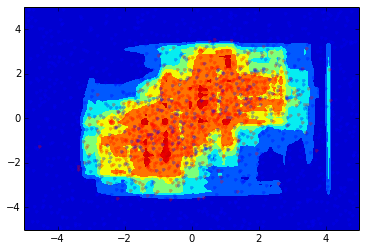

In [48]:
aa = np.linspace(-5, 5, 100)
bb = np.linspace(-5, 5, 100)
zs = np.zeros((100,100))

for ix1, a in enumerate(aa):
    for ix2, b in enumerate(bb):
        zs[ix1, ix2] = sum([tree.classify([a, b]) for tree in tforest])/len(tforest)
plt.contourf(aa, bb, zs.T)

np.random.seed(1234)
nset = 500
xp11 = np.random.randn(nset,1)-1
xp21 = np.random.randn(nset,1)-1

xp12 = np.random.randn(nset,1)+1
xp22 = np.random.randn(nset,1)+1

xp1 = np.concatenate((xp11, xp12))
xp2 = np.concatenate((xp21, xp22))

pcls = np.zeros((nset*2))
pcls[:] = 1

xn1 = np.random.random((nset*2,1))*10-5
xn2 = np.random.random((nset*2,1))*10-5
ncls = np.zeros((1000))
ncls[:] = -1

x1s = np.concatenate([xp1, xn1])
x2s = np.concatenate([xp2, xn2])
cls = np.concatenate([pcls, ncls])
features = np.concatenate((x1s, x2s), axis=1)

cls>0
plt.plot(features[cls>0, 0], features[cls>0, 1], '.r', alpha=0.3)
plt.plot(features[cls<0, 0], features[cls<0, 1], '.b', alpha=0.3)
plt.xlim(-5, 5)
plt.ylim(-5, 5)